# Insurance Claim Prediciton

What we can predict in this dataset?
1. __Claim Amount:__ total claims amount per policy holder.
1. __Claim Frequency:__ Number of claims per policy holder per exposure unit `Claim Frequency = Claim Count / Exposure`.
1. __Claim Severity:__ the average claim amount per claim for each policy holder per exposure unit `Claim Severity = Claim Cost / Claim Frequency`.
1. __Avg Claim amount:__ `Avg Claim amount = Claim Amount / Claim Count`
1. __Loss Cost:__ `Loss Cost = Claim Frequency x Claim Severity`
1. __Pure Premium:__ the mean of the total claim amount per exposure unit (the average loss per exposure) `PurePremium  = Claim Amount / Exposure`.

In [1]:
# !conda update scikit-learn -y
#!pip install -U scikit-learn

In [2]:
import sklearn
sklearn.__version__ 

'0.24.1'

In [3]:
print(__doc__)

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

Automatically created module for IPython interactive environment


We have 6780013 individual car insurance policies and for each policy we have 12 variables
1. IDpol: policy number (unique identifier);
2. ClaimNb: number of claims on the given policy;
3. Exposure: total exposure in yearly units;
4. Area: area code (categorical, ordinal);
5. VehPower: power of the car (categorical, ordinal);
6. VehAge: age of the car in years;
7. DrivAge: age of the (most common) driver in years;
8. BonusMalus: bonus-malus level between 50 and 230 (with reference level 100);
9. VehBrand: car brand (categorical, nominal);
10. VehGas: diesel or regular fuel car (binary);
11. Density: density of inhabitants per km2
in the city of the living place of the driver;
12. Region: regions in France (prior to 2016), these are illustrated in Figure 1 (categorical).

In [4]:
df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
df_freq.head(10)

/opt/conda/lib/python3.7/site-packages/sklearn/datasets/_openml.py:854: UserWarning: Version 1 of dataset freMTPL2freq is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649148/freMTPL2freq.arff
  data_description['url']))


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
5,13.0,1.0,0.52,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31
6,15.0,1.0,0.45,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31
7,17.0,1.0,0.27,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91
8,18.0,1.0,0.71,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91
9,21.0,1.0,0.15,B,7.0,0.0,41.0,50.0,B12,Diesel,60.0,R52


In [5]:
df_sev = fetch_openml(data_id=41215, as_frame=True)['data']
df_sev.head()

/opt/conda/lib/python3.7/site-packages/sklearn/datasets/_openml.py:854: UserWarning: Version 1 of dataset freMTPL2sev is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649149/freMTPL2sev.arff
  data_description['url']))


,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


In [6]:
def load_mtpl2(n_samples=100000):
    """Fetch the French Motor Third-Party Liability Claims dataset.

    Parameters
    ----------
    n_samples: int, default=100000
      number of samples to select (for faster run time). Full dataset has
      678013 samples.
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True)['data']
    df_freq['IDpol'] = df_freq['IDpol'].astype(np.int)
    df_freq.set_index('IDpol', inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)['data']

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby('IDpol').sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # unquote string fields
    for column_name in df.columns[df.dtypes.values == np.object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]

### Loading datasets, basic feature extraction and target definitions¶
We construct the freMTPL2 dataset by joining the freMTPL2freq table, containing the number of claims (ClaimNb), with the freMTPL2sev table, containing the claim amount (ClaimAmount) for the same policy ids (IDpol).

In [7]:
df = load_mtpl2(n_samples=60000)

# Note: filter out claims with zero amount, as the severity model
# requires strictly positive target values.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0
df.head()

/opt/conda/lib/python3.7/site-packages/sklearn/datasets/_openml.py:854: UserWarning: Version 1 of dataset freMTPL2freq is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649148/freMTPL2freq.arff
  data_description['url']))
/opt/conda/lib/python3.7/site-packages/sklearn/datasets/_openml.py:854: UserWarning: Version 1 of dataset freMTPL2sev is inactive, meaning that issues have been found in the dataset. Try using a newer version from this URL: https://www.openml.org/data/v1/download/20649149/freMTPL2sev.arff
  data_description['url']))


,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1,0.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
3,0.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
5,0.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
10,0.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
11,0.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0


In [8]:
# Correct for unreasonable observations (that might be data error)
# and a few exceptionally large claim amounts
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)


In [9]:
df.reset_index(inplace=True)

In [10]:
df.shape

(60000, 13)

In [11]:
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1,0.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
1,3,0.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
2,5,0.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
3,10,0.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
4,11,0.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0


In [73]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log),
    StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=3),["VehAge", "DrivAge"]),
        ("onehot_categorical", OneHotEncoder(), ["VehBrand", "VehPower", "VehGas", "Region", "Area"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        ("passthrough_numeric", "passthrough",["IDpol","VehAge", "DrivAge","VehBrand", "VehPower", "VehGas", "Region", "Area", "ClaimNb","Exposure", "BonusMalus", "ClaimAmount"]),
    ],
    remainder="drop",
    sparse_threshold=0.0,

)
X = column_trans.fit_transform(df)
X.shape

(60000, 72)

In [74]:
print(X[0,:])

[1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 1.0 0.0 0.0 0.6971986019415635 1 0.0 55.0 'B12' 5.0 'Regular'
 'R82' 'D' 0.0 0.1 50.0 0.0]


In [75]:
bins=[]
for j,f in enumerate(["VehAge","DrivAge"]):
    for idx, val in enumerate(column_trans.transformers_[0][1].bin_edges_[j]):
        edge1= column_trans.transformers_[0][1].bin_edges_[j][idx-1]
        if idx>0:
            bins.append(f+"_bin"+str(edge1)+"_"+str(val))
column_trans.transformers_[1][1].get_feature_names(["VehBrand", "VehPower", "VehGas", "Region", "Area"])
feature_names = bins+\
    column_trans.transformers_[1][1].get_feature_names(["VehBrand", "VehPower", "VehGas", "Region", "Area"]).tolist()+\
    ["Density"]+\
    ["IDpol","VehAge", "DrivAge","VehBrand", "VehPower", "VehGas", "Region", "Area","ClaimNb","Exposure","BonusMalus","ClaimAmount"]


len(feature_names)

72

In [76]:
X.shape

(60000, 72)

In [77]:
feature_names = [x.replace('.','_') for x in feature_names]
feature_names

['VehAge_bin0_0_4_0',
 'VehAge_bin4_0_10_0',
 'VehAge_bin10_0_100_0',
 'DrivAge_bin18_0_36_0',
 'DrivAge_bin36_0_50_0',
 'DrivAge_bin50_0_99_0',
 'VehBrand_B1',
 'VehBrand_B10',
 'VehBrand_B11',
 'VehBrand_B12',
 'VehBrand_B13',
 'VehBrand_B14',
 'VehBrand_B2',
 'VehBrand_B3',
 'VehBrand_B4',
 'VehBrand_B5',
 'VehBrand_B6',
 'VehPower_4_0',
 'VehPower_5_0',
 'VehPower_6_0',
 'VehPower_7_0',
 'VehPower_8_0',
 'VehPower_9_0',
 'VehPower_10_0',
 'VehPower_11_0',
 'VehPower_12_0',
 'VehPower_13_0',
 'VehPower_14_0',
 'VehPower_15_0',
 'VehGas_Diesel',
 'VehGas_Regular',
 'Region_R11',
 'Region_R21',
 'Region_R22',
 'Region_R23',
 'Region_R24',
 'Region_R25',
 'Region_R26',
 'Region_R31',
 'Region_R41',
 'Region_R42',
 'Region_R43',
 'Region_R52',
 'Region_R53',
 'Region_R54',
 'Region_R72',
 'Region_R73',
 'Region_R74',
 'Region_R82',
 'Region_R83',
 'Region_R91',
 'Region_R93',
 'Region_R94',
 'Area_A',
 'Area_B',
 'Area_C',
 'Area_D',
 'Area_E',
 'Area_F',
 'Density',
 'IDpol',
 'VehAge'

In [78]:
df_transformed = pd.DataFrame(data=X, columns= feature_names)
#df_transformed.columns= feature_names
df_transformed.head()

,VehAge_bin0_0_4_0,VehAge_bin4_0_10_0,VehAge_bin10_0_100_0,DrivAge_bin18_0_36_0,DrivAge_bin36_0_50_0,DrivAge_bin50_0_99_0,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,DrivAge,VehBrand,VehPower,VehGas,Region,Area,ClaimNb,Exposure,BonusMalus,ClaimAmount
0,1,0,0,0,0,1,0,0,0,1,...,55,B12,5,Regular,R82,D,0,0.1,50,0
1,1,0,0,0,0,1,0,0,0,1,...,55,B12,5,Regular,R82,D,0,0.77,50,0
2,1,0,0,0,0,1,0,0,0,1,...,52,B12,6,Diesel,R22,B,0,0.75,50,0
3,1,0,0,0,1,0,0,0,0,1,...,46,B12,7,Diesel,R72,B,0,0.09,50,0
4,1,0,0,0,1,0,0,0,0,1,...,46,B12,7,Diesel,R72,B,0,0.84,50,0


Insurances companies are interested in modeling the Pure Premium, that is the expected total claim amount per unit of exposure for each policyholder in their portfolio:

In [79]:
df_transformed["PurePremium"] = df_transformed["ClaimAmount"] / df_transformed["Exposure"]

This can be indirectly approximated by a 2-step modeling: the product of the Frequency times the average claim amount per claim:

In [80]:
df_transformed["Frequency"] = df_transformed["ClaimNb"] / df_transformed["Exposure"]
df_transformed["AvgClaimAmount"] = df_transformed["ClaimAmount"] / np.fmax(df_transformed["ClaimNb"], 1)

In [81]:
df_transformed[df_transformed.ClaimNb>0].head(20)

,VehAge_bin0_0_4_0,VehAge_bin4_0_10_0,VehAge_bin10_0_100_0,DrivAge_bin18_0_36_0,DrivAge_bin36_0_50_0,DrivAge_bin50_0_99_0,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,VehGas,Region,Area,ClaimNb,Exposure,BonusMalus,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
66,1,0,0,0,0,1,0,0,0,1,...,Regular,R11,F,1,0.75,50,303,404,1.33333,303
93,0,1,0,0,0,1,0,0,0,1,...,Diesel,R25,B,1,0.14,60,1981.84,14156,7.14286,1981.84
199,1,0,0,0,1,0,0,0,0,1,...,Regular,R11,E,1,0.14,85,1456.55,10403.9,7.14286,1456.55
205,1,0,0,0,0,1,0,0,0,1,...,Regular,R11,F,2,0.62,100,10834,17474.2,3.22581,5417
223,1,0,0,0,1,0,0,0,0,1,...,Regular,R73,A,1,0.31,50,3986.67,12860.2,3.22581,3986.67
287,0,1,0,0,0,1,0,0,0,1,...,Diesel,R93,D,1,0.84,50,1840.14,2190.64,1.19048,1840.14
295,1,0,0,1,0,0,0,0,0,1,...,Regular,R31,D,1,0.75,64,1397.97,1863.96,1.33333,1397.97
388,1,0,0,0,1,0,0,0,0,1,...,Regular,R93,E,1,0.76,50,971.98,1278.92,1.31579,971.98
396,0,0,1,1,0,0,1,0,0,0,...,Regular,R11,E,1,0.68,105,1442.75,2121.69,1.47059,1442.75
468,1,0,0,0,0,1,0,0,0,1,...,Regular,R93,D,1,0.73,50,637.41,873.164,1.36986,637.41


## Feature store

In [82]:
df_transformed.dtypes

VehAge_bin0_0_4_0       object
VehAge_bin4_0_10_0      object
VehAge_bin10_0_100_0    object
DrivAge_bin18_0_36_0    object
DrivAge_bin36_0_50_0    object
                         ...  
BonusMalus              object
ClaimAmount             object
PurePremium             object
Frequency               object
AvgClaimAmount          object
Length: 75, dtype: object

### 1- Define dataset

In [83]:
df_data = df_transformed.copy()

In [84]:
#df_data.reset_index(inplace=True)

In [85]:
import boto3
import sagemaker
from sagemaker.session import Session


region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

#### S3 Bucket Setup For The OfflineStore

SageMaker FeatureStore writes the data in the OfflineStore of a FeatureGroup to a S3 bucket owned by you. To be able to write to your S3 bucket, SageMaker FeatureStore assumes an IAM role which has access to it. The role is also owned by you.
Note that the same bucket can be re-used across FeatureGroups. Data in the bucket is partitioned by FeatureGroup.

Set the default s3 bucket name and it will be referenced throughout the notebook.

In [86]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-insurance'

print(default_s3_bucket_name)

sagemaker-us-east-1-079329190341


Set up the IAM role. This role gives SageMaker FeatureStore access to your S3 bucket. 

<div class="alert alert-block alert-warning">
<b>Note:</b> In this example we use the default SageMaker role, assuming it has both <b>AmazonSageMakerFullAccess</b> and <b>AmazonSageMakerFeatureStoreAccess</b> managed policies. If not, please make sure to attach them to the role before proceeding.
</div>

In [87]:
from sagemaker import get_execution_role

# You can modify the following to use a role of your choosing. See the documentation for how to create this.
role = get_execution_role()
print (role)

arn:aws:iam::079329190341:role/workshop-role


### 2- Define Feature Group

In [88]:
from time import gmtime, strftime, sleep

insurance_policy_feature_group_name = 'insurance-policy-feature-group-' + strftime('%d-%H-%M-%S', gmtime())

In [89]:
from sagemaker.feature_store.feature_group import FeatureGroup

insurance_policy_feature_group = FeatureGroup(name=insurance_policy_feature_group_name, sagemaker_session=feature_store_session)

In [90]:
import time

current_time_sec = int(round(time.time()))

def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label].name in ['object','category']:
            data_frame[label] = data_frame[label].astype("str").astype("string")

# cast object dtype to string. The SageMaker FeatureStore Python SDK will then map the string dtype to String feature type.
cast_object_to_string(df_data)



In [91]:
df_data.dtypes

VehAge_bin0_0_4_0       string
VehAge_bin4_0_10_0      string
VehAge_bin10_0_100_0    string
DrivAge_bin18_0_36_0    string
DrivAge_bin36_0_50_0    string
                         ...  
BonusMalus              string
ClaimAmount             string
PurePremium             string
Frequency               string
AvgClaimAmount          string
Length: 75, dtype: object

In [92]:
# record identifier and event time feature names
record_identifier_feature_name = "IDpol"
event_time_feature_name = "EventTime"

# append EventTime feature
df_data[event_time_feature_name] = pd.Series([current_time_sec]*len(df_data), dtype="float64")

In [93]:
df_data.head()

,VehAge_bin0_0_4_0,VehAge_bin4_0_10_0,VehAge_bin10_0_100_0,DrivAge_bin18_0_36_0,DrivAge_bin36_0_50_0,DrivAge_bin50_0_99_0,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,Region,Area,ClaimNb,Exposure,BonusMalus,ClaimAmount,PurePremium,Frequency,AvgClaimAmount,EventTime
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,R82,D,0.0,0.1,50.0,0.0,0.0,0.0,0.0,1.612749e+09
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,R82,D,0.0,0.77,50.0,0.0,0.0,0.0,0.0,1.612749e+09
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,R22,B,0.0,0.75,50.0,0.0,0.0,0.0,0.0,1.612749e+09
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,R72,B,0.0,0.09,50.0,0.0,0.0,0.0,0.0,1.612749e+09
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,R72,B,0.0,0.84,50.0,0.0,0.0,0.0,0.0,1.612749e+09


In [94]:

# load feature definitions to the feature group. SageMaker FeatureStore Python SDK will auto-detect the data schema based on input data.
insurance_policy_feature_group.load_feature_definitions(data_frame=df_data); # output is suppressed


#### 3- Deploy FeatureGroups in SageMaker FeatureStore

In [95]:
def wait_for_feature_group_creation_complete(feature_group):
    status = feature_group.describe().get("FeatureGroupStatus")
    while status == "Creating":
        print("Waiting for Feature Group Creation")
        time.sleep(5)
        status = feature_group.describe().get("FeatureGroupStatus")
    if status != "Created":
        raise RuntimeError(f"Failed to create feature group {feature_group.name}")
    print(f"FeatureGroup {feature_group.name} successfully created.")

insurance_policy_feature_group.create(
    s3_uri=f"s3://{default_s3_bucket_name}/{prefix}",
    record_identifier_name=record_identifier_feature_name,
    event_time_feature_name=event_time_feature_name,
    role_arn=role,
    enable_online_store=True
)

wait_for_feature_group_creation_complete(feature_group=insurance_policy_feature_group)


Waiting for Feature Group Creation
Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup insurance-policy-feature-group-08-01-57-39 successfully created.


In [96]:
insurance_policy_feature_group.describe()

{'FeatureGroupArn': 'arn:aws:sagemaker:us-east-1:079329190341:feature-group/insurance-policy-feature-group-08-01-57-39',
 'FeatureGroupName': 'insurance-policy-feature-group-08-01-57-39',
 'RecordIdentifierFeatureName': 'IDpol',
 'EventTimeFeatureName': 'EventTime',
 'FeatureDefinitions': [{'FeatureName': 'VehAge_bin0_0_4_0',
   'FeatureType': 'String'},
  {'FeatureName': 'VehAge_bin4_0_10_0', 'FeatureType': 'String'},
  {'FeatureName': 'VehAge_bin10_0_100_0', 'FeatureType': 'String'},
  {'FeatureName': 'DrivAge_bin18_0_36_0', 'FeatureType': 'String'},
  {'FeatureName': 'DrivAge_bin36_0_50_0', 'FeatureType': 'String'},
  {'FeatureName': 'DrivAge_bin50_0_99_0', 'FeatureType': 'String'},
  {'FeatureName': 'VehBrand_B1', 'FeatureType': 'String'},
  {'FeatureName': 'VehBrand_B10', 'FeatureType': 'String'},
  {'FeatureName': 'VehBrand_B11', 'FeatureType': 'String'},
  {'FeatureName': 'VehBrand_B12', 'FeatureType': 'String'},
  {'FeatureName': 'VehBrand_B13', 'FeatureType': 'String'},
  {'Fe

In [97]:
#sagemaker_client.list_feature_groups()

In [98]:
!aws s3 ls s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/079329190341/sagemaker/us-east-1/offline-store/insurance-policy-feature-group-06-20-23-32/

                           PRE data/
2021-02-06 21:03:42          0 insurance-policy-feature-group-06-20-23-322021-02-06T20:23:43.765Z.txt


#### 4- Ingest data into FeatureStore

#### PutRecords into FeatureGroup

After the FeatureGroups have been created, we can put data into the FeatureGroups by using the PutRecord API. This API can handle high TPS and is designed to be called by different streams. The data from all of these Put requests is buffered and written to S3 in chunks. The files will be written to the offline store within a few minutes of ingestion. For this example, to accelerate the ingestion process, we are specifying multiple workers to do the job simultaneously. It will take ~1min to ingest data to the 2 FeatureGroups, respectively.

In [99]:
insurance_policy_feature_group.ingest(
    data_frame=df_data, max_workers=5, wait=True
)

IngestionManagerPandas(feature_group_name='insurance-policy-feature-group-08-01-57-39', sagemaker_session=<sagemaker.session.Session object at 0x7f2c771d9fd0>, data_frame=      VehAge_bin0_0_4_0 VehAge_bin4_0_10_0 VehAge_bin10_0_100_0  \
0                   1.0                0.0                  0.0   
1                   1.0                0.0                  0.0   
2                   1.0                0.0                  0.0   
3                   1.0                0.0                  0.0   
4                   1.0                0.0                  0.0   
...                 ...                ...                  ...   
59995               1.0                0.0                  0.0   
59996               1.0                0.0                  0.0   
59997               0.0                1.0                  0.0   
59998               0.0                1.0                  0.0   
59999               0.0                1.0                  0.0   

      DrivAge_bin18_0_36

To confirm that data has been ingested, we can quickly retrieve a record from the online store:

In [100]:
!aws s3 ls s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/079329190341/sagemaker/us-east-1/offline-store/insurance-policy-feature-group-06-20-23-32/ 

                           PRE data/
2021-02-06 21:03:42          0 insurance-policy-feature-group-06-20-23-322021-02-06T20:23:43.765Z.txt


In [101]:
insurance_policy_feature_group

FeatureGroup(name='insurance-policy-feature-group-08-01-57-39', sagemaker_session=<sagemaker.session.Session object at 0x7f2c771d9fd0>, feature_definitions=[FeatureDefinition(feature_name='VehAge_bin0_0_4_0', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='VehAge_bin4_0_10_0', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='VehAge_bin10_0_100_0', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='DrivAge_bin18_0_36_0', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='DrivAge_bin36_0_50_0', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='DrivAge_bin50_0_99_0', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='VehBrand_B1', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='VehBrand_B10', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature

In [102]:
record_identifier_value = str(15)

#featurestore_runtime.get_record(FeatureGroupName=insurance_policy_feature_group, RecordIdentifierValueAsString=record_identifier_value)

The SageMaker Python SDK’s FeatureStore class also provides the functionality to generate Hive DDL commands. Schema of the table is generated based on the feature definitions. Columns are named after feature name and data-type are inferred based on feature type.

In [103]:
print(insurance_policy_feature_group.as_hive_ddl())

CREATE EXTERNAL TABLE IF NOT EXISTS sagemaker_featurestore.insurance-policy-feature-group-08-01-57-39 (
  VehAge_bin0_0_4_0 STRING
  VehAge_bin4_0_10_0 STRING
  VehAge_bin10_0_100_0 STRING
  DrivAge_bin18_0_36_0 STRING
  DrivAge_bin36_0_50_0 STRING
  DrivAge_bin50_0_99_0 STRING
  VehBrand_B1 STRING
  VehBrand_B10 STRING
  VehBrand_B11 STRING
  VehBrand_B12 STRING
  VehBrand_B13 STRING
  VehBrand_B14 STRING
  VehBrand_B2 STRING
  VehBrand_B3 STRING
  VehBrand_B4 STRING
  VehBrand_B5 STRING
  VehBrand_B6 STRING
  VehPower_4_0 STRING
  VehPower_5_0 STRING
  VehPower_6_0 STRING
  VehPower_7_0 STRING
  VehPower_8_0 STRING
  VehPower_9_0 STRING
  VehPower_10_0 STRING
  VehPower_11_0 STRING
  VehPower_12_0 STRING
  VehPower_13_0 STRING
  VehPower_14_0 STRING
  VehPower_15_0 STRING
  VehGas_Diesel STRING
  VehGas_Regular STRING
  Region_R11 STRING
  Region_R21 STRING
  Region_R22 STRING
  Region_R23 STRING
  Region_R24 STRING
  Region_R25 STRING
  Region_R26 STRING
  Region_R31 STRING
  Region

Now let's wait for the data to appear in our offline store before moving forward to creating a dataset. This will take approximately 5 minutes.

In [104]:
account_id = boto3.client('sts').get_caller_identity()["Account"]
print(account_id)

insurance_policy_feature_group_s3_prefix = prefix + '/' + account_id + '/sagemaker/' + region + '/offline-store/' + insurance_policy_feature_group_name + '/data'
print(insurance_policy_feature_group_s3_prefix)

079329190341
sagemaker-featurestore-insurance/079329190341/sagemaker/us-east-1/offline-store/insurance-policy-feature-group-08-01-57-39/data


In [105]:
prefix

'sagemaker-featurestore-insurance'

In [106]:
default_s3_bucket_name

'sagemaker-us-east-1-079329190341'

In [107]:
s3_client = boto3.client('s3', region_name=region)
account_id = boto3.client('sts').get_caller_identity()["Account"]
print(account_id)

insurance_policy_feature_group_s3_prefix = prefix + '/' + account_id + '/sagemaker/' + region + '/offline-store/' + insurance_policy_feature_group_name + '/data'

offline_store_contents = None
while (offline_store_contents is None):
    objects_in_bucket = s3_client.list_objects(Bucket=default_s3_bucket_name,Prefix=insurance_policy_feature_group_s3_prefix)
    if ('Contents' in objects_in_bucket and len(objects_in_bucket['Contents']) > 1):
        offline_store_contents = objects_in_bucket['Contents']
    else:
        print('Waiting for data in offline store...\n')
        sleep(60)
    
print('Data available.')

079329190341
Data available.


SageMaker FeatureStore adds metadata for each record that's ingested into the offline store.

## Build Training Dataset

SageMaker FeatureStore automatically builds the Glue Data Catalog for FeatureGroups (you can optionally turn it on/off while creating the FeatureGroup). In this example, we want to create one training dataset with FeatureValues from both identity and transaction FeatureGroups. This is done by utilizing the auto-built Catalog. We run an Athena query that joins the data stored in the offline store in S3 from the 2 FeatureGroups. 

In [108]:
insurance_policy_query = insurance_policy_feature_group.athena_query()

insurance_policy_table = insurance_policy_query.table_name

query_string = 'SELECT * FROM "'+insurance_policy_table+'"' #+insurance_policy_table
print('Running ' + query_string)

# run Athena query. The output is loaded to a Pandas dataframe.
#dataset = pd.DataFrame()
insurance_policy_query.run(query_string=query_string, output_location='s3://'+default_s3_bucket_name+'/'+prefix+'/query_results/')
insurance_policy_query.wait()
dataset = insurance_policy_query.as_dataframe()

dataset

Running SELECT * FROM "insurance-policy-feature-group-08-01-57-39-1612749467"


,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,vehbrand_b12,...,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount,eventtime,write_time,api_invocation_time,is_deleted
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.84,50.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.30,68.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.29,83.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.13,85.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.76,50.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54270,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.06,50.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:58:59.423,2021-02-08 01:58:47.000,False
54271,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.58,95.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:58:59.423,2021-02-08 01:58:47.000,False
54272,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.00,50.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:58:59.423,2021-02-08 01:58:47.000,False
54273,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.48,54.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:58:59.423,2021-02-08 01:58:47.000,False


In [109]:
# Prepare query results for training.
query_execution = insurance_policy_query.get_query_execution()
query_result = 's3://'+default_s3_bucket_name+'/'+prefix+'/query_results/'+query_execution['QueryExecution']['QueryExecutionId']+'.csv'
print(query_result)

s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/query_results/abf75642-489e-449d-a1f1-584c9fe7dec4.csv


In [110]:
!aws s3 ls s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/query_results/

2021-02-08 01:06:19   30408611 12695db1-7b67-403b-b2de-ac058aacee47.csv
2021-02-08 01:06:20       3656 12695db1-7b67-403b-b2de-ac058aacee47.csv.metadata
2021-02-08 01:39:51   28272957 3526e5fa-9439-4d8e-9e41-f89020c1535e.csv
2021-02-08 01:39:51       3656 3526e5fa-9439-4d8e-9e41-f89020c1535e.csv.metadata
2021-02-06 23:32:36   10886889 96e44858-5e29-4065-bf0e-c6af38cf5d8c.csv
2021-02-06 23:32:37        962 96e44858-5e29-4065-bf0e-c6af38cf5d8c.csv.metadata
2021-02-08 02:01:38   29742511 abf75642-489e-449d-a1f1-584c9fe7dec4.csv
2021-02-08 02:01:39       4317 abf75642-489e-449d-a1f1-584c9fe7dec4.csv.metadata
2021-02-07 06:37:12   10886889 d9573523-32e5-4a39-8d5e-50e0b751a8db.csv
2021-02-07 06:37:12        962 d9573523-32e5-4a39-8d5e-50e0b751a8db.csv.metadata


In [151]:
df_features = pd.read_csv(query_result)

In [152]:
df_features.head()

,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,vehbrand_b12,...,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount,eventtime,write_time,api_invocation_time,is_deleted
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.84,50.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.30,68.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.29,83.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.13,85.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.76,50.0,0.0,0.0,0.0,0.0,1.612749e+09,2021-02-08 01:59:29.732,2021-02-08 01:58:47.000,False


In [153]:
# # Select useful columns for training with target column as the first.
# dataset = dataset[["isfraud", "transactiondt", "transactionamt", "card1", "card2", "card3", "card5", "card_type_credit", "card_type_debit", "card_bank_american_express", "card_bank_discover", "card_bank_mastercard", "card_bank_visa", "id_01", "id_02", "id_03", "id_04", "id_05"]]

# # Write to csv in S3 without headers and index column.
# dataset.to_csv('dataset.csv', header=False, index=False)
# s3_client.upload_file('dataset.csv', default_s3_bucket_name, prefix+'/training_input/dataset.csv')
# dataset_uri_prefix = 's3://'+default_s3_bucket_name+'/'+prefix+'/training_input/';

# dataset

# Frequency model – Poisson distribution

If the target values  are counts (non-negative integer valued) or relative frequencies (non-negative), you might use a Poisson deviance with log-link.

The number of claims (ClaimNb) is a positive integer (0 included). Thus, this target can be modelled by a Poisson distribution. It is then assumed to be the number of discrete events occuring with a constant rate in a given time interval (Exposure, in units of years). Here we model the frequency y = ClaimNb / Exposure, which is still a (scaled) Poisson distribution, and use Exposure as sample_weight.


In [167]:
feature_names = feature_names+['PurePremium','Frequency','AvgClaimAmount','eventtime','write_time','api_invocation_time','is_deleted']
df_features.columns = feature_names

In [174]:
df_modeling = df_features.iloc[:,0:60]
# colnames = ['IDpol'] + df.columns.values.tolist()
#df_modeling.columns = colnames

df_modeling.head()

,VehAge_bin0_0_4_0,VehAge_bin4_0_10_0,VehAge_bin10_0_100_0,DrivAge_bin18_0_36_0,DrivAge_bin36_0_50_0,DrivAge_bin50_0_99_0,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,Region_R91,Region_R93,Region_R94,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,Density
0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.704324
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.571190
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.518775
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.972742
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.293832


In [175]:
y_df = df_features.iloc[:,60:75]
y_df.head()

,IDpol,VehAge,DrivAge,VehBrand,VehPower,VehGas,Region,Area,ClaimNb,Exposure,BonusMalus,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
0,77553,11.0,53.0,B1,4.0,Regular,R31,D,0.0,0.84,50.0,0.0,0.0,0.0,0.0
1,5144,0.0,27.0,B12,6.0,Diesel,R26,D,0.0,0.30,68.0,0.0,0.0,0.0,0.0
2,102389,13.0,38.0,B6,8.0,Diesel,R24,C,0.0,0.29,83.0,0.0,0.0,0.0,0.0
3,5146,4.0,25.0,B12,10.0,Diesel,R26,B,0.0,0.13,85.0,0.0,0.0,0.0,0.0
4,56168,11.0,58.0,B6,8.0,Diesel,R82,D,0.0,0.76,50.0,0.0,0.0,0.0,0.0


In [176]:
X_train, X_test, y_train, y_test = train_test_split(df_modeling, y_df, random_state=0)

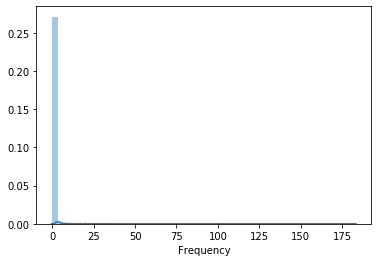

In [177]:
import seaborn as sns
sns.distplot(y_df["Frequency"], kde_kws={'bw': 0.1});


In [178]:

# The parameters of the model are estimated by minimizing the Poisson deviance
# on the training set via a quasi-Newton solver: l-BFGS. Some of the features
# are collinear, we use a weak penalization to avoid numerical issues.
glm_freq = PoissonRegressor(alpha=1e-3, max_iter=400)
glm_freq.fit(X_train, y_train["Frequency"], sample_weight=y_train["Exposure"])

PoissonRegressor(alpha=0.001, max_iter=400)

In [179]:
def score_estimator(estimator, X_train, X_test, df_train, df_test, target, weights, tweedie_powers=None,):
    """Evaluate an estimator on train and test sets with different metrics"""

    metrics = [
        ("D² explained", None),   # Use default scorer if it exists
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [(
            "mean Tweedie dev p={:.4f}".format(power),
            partial(mean_tweedie_deviance, power=power)
        ) for power in tweedie_powers]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # Score the model consisting of the product of frequency and
                # severity models.
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append(
                {"subset": subset_label, "metric": score_label, "score": score}
            )

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ['train', 'test']]
    )
    return res


scores = score_estimator(
    glm_freq,
    X_train,
    X_test,
    y_train,
    y_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0172  0.0107
mean abs. error     0.1745  0.1742
mean squared error  0.3394  0.2604


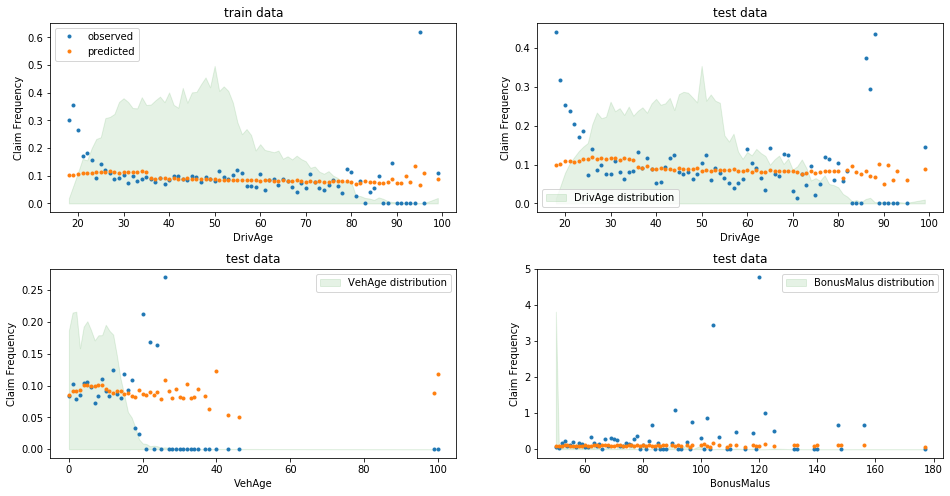

In [180]:
def plot_obs_pred(df, feature, weight, observed, predicted, y_label=None,
                  title=None, ax=None, fill_legend=False):
    """Plot observed and predicted - aggregated per feature level.

    Parameters
    ----------
    df : DataFrame
        input data
    feature: str
        a column name of df for the feature to be plotted
    weight : str
        column name of df with the values of weights or exposure
    observed : str
        a column name of df with the observed target
    predicted : DataFrame
        a dataframe, with the same index as df, with the predicted target
    fill_legend : bool, default=False
        whether to show fill_between legend
    """
    # aggregate observed and predicted variables by feature level
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=y_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0, 0],
)

plot_obs_pred(
    df=y_test,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 1],
    fill_legend=True
)

plot_obs_pred(
    df=y_test,
    feature="VehAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 0],
    fill_legend=True
)

plot_obs_pred(
    df=y_test,
    feature="BonusMalus",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 1],
    fill_legend=True
)


# Severity Model - Gamma distribution

 the target values are positive valued and skewed, you might try a Gamma deviance with log-link.
 
The mean claim amount or severity (AvgClaimAmount) can be empirically shown to follow approximately a Gamma distribution. We fit a GLM model for the severity with the same features as the frequency model.

Note:

We filter out ClaimAmount == 0 as the Gamma distribution has support on , not .

We use ClaimNb as sample_weight to account for policies that contain more than one claim.

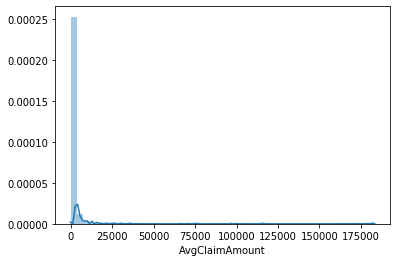

In [181]:
import seaborn as sns
mask_train = y_train["ClaimAmount"] > 0
sns.distplot(y_train.loc[mask_train, "AvgClaimAmount"]);

In [182]:
mask_train = y_train["ClaimAmount"] > 0
mask_test = y_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10., max_iter=10000)

glm_sev.fit(
    X_train[mask_train.values],
    y_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=y_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    glm_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    y_train[mask_train],
    y_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        4.700000e-03 -1.680000e-02
mean abs. error     1.986314e+03  1.742140e+03
mean squared error  6.110608e+07  2.495480e+07


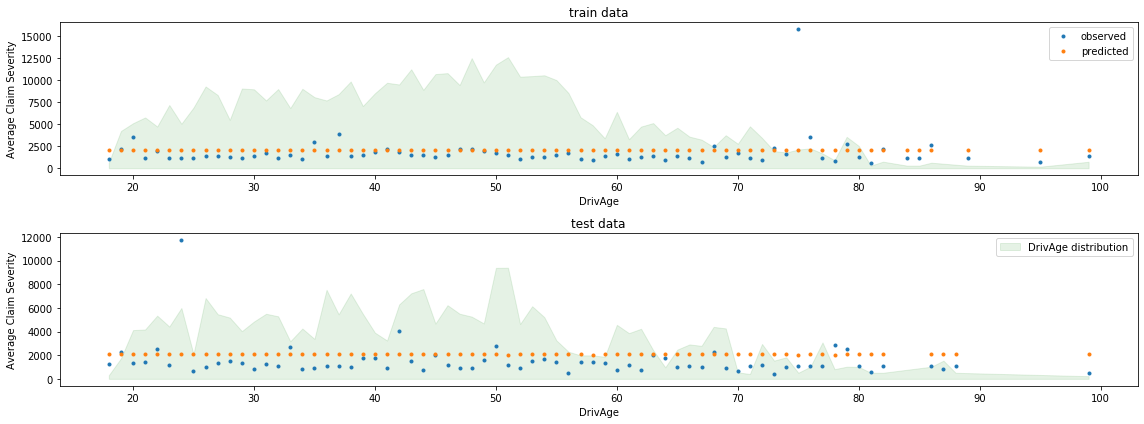

In [183]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(
    df=y_train.loc[mask_train],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_train[mask_train.values]),
    y_label="Average Claim Severity",
    title="train data",
    ax=ax[0],
)

plot_obs_pred(
    df=y_test.loc[mask_test],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_test[mask_test.values]),
    y_label="Average Claim Severity",
    title="test data",
    ax=ax[1],
    fill_legend=True
)
plt.tight_layout()

Overall, the drivers `age (DrivAge)` has a weak impact on the claim severity, both in observed and predicted data.

# Pure Premium Modeling

Insurances companies are interested in modeling the `Pure Premium`, that is the expected total claim amount per unit of exposure for each policyholder in their portfolio. That is the `PurePremium  = ClaimAmount/Exposure`

The Pure Premium (total claim amount per unit of exposure) can be modeled one of these approachs: 
- Product Model: the product of the prediction of the frequency model by the prediction of the severity model.
- TweedieRegressor: one can directly model the total loss with a unique Compound Poisson Gamma generalized linear model (with a log link function). This model is a special case of the Tweedie GLM with a “power” parameter . 




#### Pure Premium Modeling using Product Model

In [184]:
tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    y_train,
    y_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)
scores_product_model

subset,train,test
metric,,
mean Tweedie dev p=1.5000,8.992620e+01,8.205910e+01
mean Tweedie dev p=1.7000,4.060660e+01,3.855830e+01
mean Tweedie dev p=1.8000,3.233400e+01,3.123780e+01
mean Tweedie dev p=1.9000,3.468970e+01,3.405990e+01
mean Tweedie dev p=1.9900,1.995797e+02,1.986879e+02
mean Tweedie dev p=1.9990,1.889153e+03,1.883260e+03
mean Tweedie dev p=1.9999,1.878813e+04,1.873206e+04
mean abs. error,3.638918e+02,3.362209e+02
mean squared error,1.703307e+08,7.753114e+06


#### Pure Premium Modeling using TweedieRegressor

In [186]:
glm_pure_premium = TweedieRegressor(power=1.9, alpha=.1, max_iter=10000)
glm_pure_premium.fit(X_train, y_train["PurePremium"],
                     sample_weight=y_train["Exposure"])
scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    y_train,
    y_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers
)
scores_glm_pure_premium

subset,train,test
metric,,
D² explained,1.270000e-02,-3.000000e-04
mean Tweedie dev p=1.5000,8.764030e+01,8.306470e+01
mean Tweedie dev p=1.7000,3.983690e+01,3.891320e+01
mean Tweedie dev p=1.8000,3.188630e+01,3.144900e+01
mean Tweedie dev p=1.9000,3.442890e+01,3.418570e+01
mean Tweedie dev p=1.9900,1.994191e+02,1.987670e+02
mean Tweedie dev p=1.9990,1.889000e+03,1.883335e+03
mean Tweedie dev p=1.9999,1.878798e+04,1.873214e+04
mean abs. error,3.543222e+02,3.265396e+02


#### Product Model vs single TweedieRegressor

In [187]:
scores = pd.concat([scores_product_model, scores_glm_pure_premium],
                   axis=1, sort=True,
                   keys=('Product Model', 'TweedieRegressor'))
print("Evaluation of the Product Model and the Tweedie Regressor "
      "on target PurePremium")
with pd.option_context('display.expand_frame_repr', False):
    print(scores)

Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                          Product Model               TweedieRegressor              
subset                            train          test            train          test
D² explained                        NaN           NaN     1.270000e-02 -3.000000e-04
mean Tweedie dev p=1.5000  8.992620e+01  8.205910e+01     8.764030e+01  8.306470e+01
mean Tweedie dev p=1.7000  4.060660e+01  3.855830e+01     3.983690e+01  3.891320e+01
mean Tweedie dev p=1.8000  3.233400e+01  3.123780e+01     3.188630e+01  3.144900e+01
mean Tweedie dev p=1.9000  3.468970e+01  3.405990e+01     3.442890e+01  3.418570e+01
mean Tweedie dev p=1.9900  1.995797e+02  1.986879e+02     1.994191e+02  1.987670e+02
mean Tweedie dev p=1.9990  1.889153e+03  1.883260e+03     1.889000e+03  1.883335e+03
mean Tweedie dev p=1.9999  1.878813e+04  1.873206e+04     1.878798e+04  1.873214e+04
mean abs. error            3.638918e+02  3.362209e+02     3.543222e+02

We can additionally validate these models by comparing observed and predicted total claim amount over the test and train subsets. We see that, on average, both model tend to underestimate the total claim (but this behavior depends on the amount of regularization).

In [188]:
res = []
for subset_label, X, df in [
    ("train", X_train, y_train),
    ("test", X_test, y_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, frequency*severity model": np.sum(
                exposure * glm_freq.predict(X) * glm_sev.predict(X)
            ),
            "predicted, tweedie, power=%.2f"
            % glm_pure_premium.power: np.sum(
                exposure * glm_pure_premium.predict(X)),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                      train          test
observed                             4.490553e+06  1.287880e+06
predicted, frequency*severity model  4.472593e+06  1.511519e+06
predicted, tweedie, power=1.90       4.212735e+06  1.419295e+06


#### Pure Premium Modeling using xgboost

In [189]:
#!conda install -c conda-forge xgboost -y

In [190]:
!pip install xgboost==1.0.0 

In [191]:
import xgboost

In [192]:
xgboost.__version__

'1.0.0'

Parameters:
- reg:gamma: gamma regression with log-link. Output is a mean of gamma distribution. It might be useful, e.g., for modeling insurance claims severity, or for any outcome that might be gamma-distributed.

- reg:tweedie: Tweedie regression with log-link. It might be useful, e.g., for modeling total loss in insurance, or for any outcome that might be Tweedie-distributed.

In [193]:
model_XGBRegressor = xgboost.XGBRegressor(learning_rate=0.01,max_depth=3)
model_XGBRegressor

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=3,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=False, verbosity=None)

In [194]:
X_train.shape

(40706, 60)

In [196]:
X_train_df = X_train
# X_train_df=pd.DataFrame(X_train.toarray())
# X_train_df.columns = feature_names
# X_train_df.head()

In [197]:
X_test_df = X_test
# X_test_df =pd.DataFrame(X_test.toarray())
# X_test_df.columns = feature_names
# X_test_df.head()

In [198]:
model_XGBRegressor.fit(X_train_df,y_train["PurePremium"])

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [199]:
# calculate gini
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) / np.sum(true_order)
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [200]:
y_pred_xgboost = model_XGBRegressor.predict(X_test_df)
result = Gini(y_test["PurePremium"], y_pred_xgboost)
print ('gini :%.6f '%result)

gini :-0.056336 


### Model comparision: Policy holder ranking

Is the model good enough to rank the policy holders from safest to riskiest based on predicted claim amounts, comparint with the reality?

[]

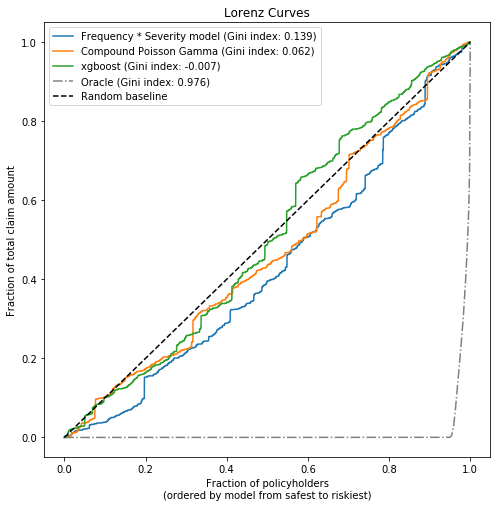

In [203]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_product = glm_freq.predict(X_test) * glm_sev.predict(X_test)
y_pred_total = glm_pure_premium.predict(X_test)
y_pred_xgboost = model_XGBRegressor.predict(X_test_df)


for label, y_pred in [("Frequency * Severity model", y_pred_product),
                      ("Compound Poisson Gamma", y_pred_total),
                     ("xgboost", y_pred_xgboost)]:
    ordered_samples, cum_claims = lorenz_curve(y_test["PurePremium"], y_pred, y_test["Exposure"])
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    y_test["PurePremium"], y_test["PurePremium"], y_test["Exposure"])
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray",
        label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black",
        label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel=('Fraction of policyholders\n'
            '(ordered by model from safest to riskiest)'),
    ylabel='Fraction of total claim amount'
)
ax.legend(loc="upper left")
plt.plot()

__Lorenz Curve:__ it represents cliam inequality. It shows for the bottom x% of ploicyholders, what percentage (y%) of the total claim they have. For example, based on compound model, the bottom 40% of policy holders who have the lowest PurePremium (safest), their total claim amount is 20% of all claims. 

__Gini index:__ imagine that each policy holder equivalently claim for $1, and we have 100 policy holders in our dataset.  No need to sort as there is no rikiest or safest policy holders. When we draw the Lorenz Curves, it is a 45 degree line.  It is the line of equality. This represents the situation where each person has an equal share of claim. Now, pick a point on the horizontal axis, say 60% of policyholders. The corresponding vertical axis is about 40% of claims for xgboost model. This represents claim inequality. The farther the Lorenz curve from the line of equality, the greater is the amount of claim inequality. The Gini coefficient is a single number aimed at measuring the degree of inequality in a distribution. G = A/(A + B). It is also equal to 2A and to 1 − 2B due to the fact that A + B = 0.5 (since the axes scale from 0 to 1).

# Model Explaibablity
Gradient boosting can automatically provide estimates of feature importance from a trained predictive model. The more a feature is used to make key decisions with decision trees, the higher its relative importance.

A trained XGBoost model automatically calculates feature importance which are available in the __feature_importances___  variable of the trained model.

In [204]:
model_XGBRegressor.get_booster().get_score(importance_type='weight')

{'Region_R11': 130,
 'VehBrand_B4': 60,
 'Density': 178,
 'Region_R31': 75,
 'VehBrand_B2': 92,
 'VehPower_6_0': 81,
 'VehAge_bin0_0_4_0': 12,
 'VehPower_12_0': 19,
 'Area_E': 49,
 'VehPower_8_0': 3,
 'VehBrand_B5': 1}

In [205]:
#!conda install -c conda-forge shap -y

Solving environment: / ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



In [206]:
import shap


In [207]:
X_test

,VehAge_bin0_0_4_0,VehAge_bin4_0_10_0,VehAge_bin10_0_100_0,DrivAge_bin18_0_36_0,DrivAge_bin36_0_50_0,DrivAge_bin50_0_99_0,VehBrand_B1,VehBrand_B10,VehBrand_B11,VehBrand_B12,...,Region_R91,Region_R93,Region_R94,Area_A,Area_B,Area_C,Area_D,Area_E,Area_F,Density
21864,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.012435
22772,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.330479
16381,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.322898
41979,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.246790
26889,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.222726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11485,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.441464
33915,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.892765
33372,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.845297
34617,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.953929


In [208]:
shap_values = shap.TreeExplainer(model_XGBRegressor).shap_values(X_train_df)
shap_values

array([[ -16.224403,    0.      ,    0.      , ...,  345.79947 ,
           0.      , -309.9931  ],
       [ -16.224403,    0.      ,    0.      , ...,  -56.42254 ,
           0.      ,  -48.920177],
       [ -58.21329 ,    0.      ,    0.      , ...,  -72.883675,
           0.      ,   -6.782065],
       ...,
       [ 361.66302 ,    0.      ,    0.      , ..., -718.83496 ,
           0.      , 2830.2024  ],
       [  42.025715,    0.      ,    0.      , ...,  -56.42254 ,
           0.      ,  -48.920177],
       [-139.62326 ,    0.      ,    0.      , ..., -160.78381 ,
           0.      ,  200.14279 ]], dtype=float32)

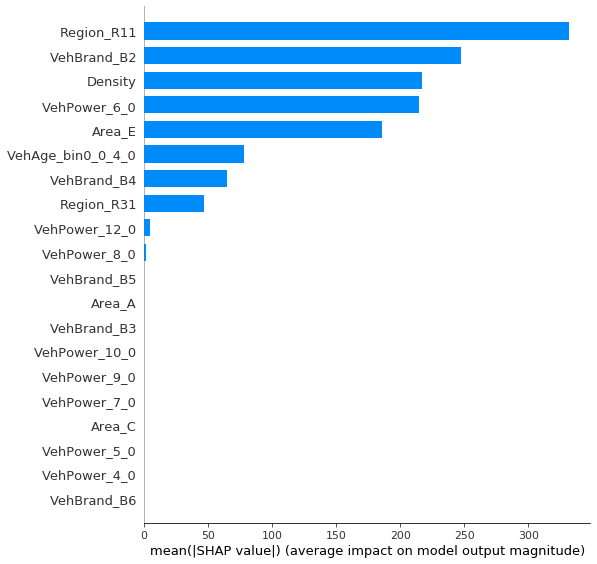

In [209]:
shap.summary_plot(shap_values, X_train_df, plot_type="bar")

In [210]:
len(feature_names)

79

In [211]:
y_pred_xgboost

array([  236.2207,   236.2207,   236.2207, ...,   236.2207, -2050.3987,
         236.2207], dtype=float32)

In [212]:
len(y_pred_xgboost)

13569

In [213]:
np.round(model_XGBRegressor.predict(X_test_df),2)

array([  236.22,   236.22,   236.22, ...,   236.22, -2050.4 ,   236.22],
      dtype=float32)

In [214]:
#Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

j=0
explainerModel = shap.TreeExplainer(model_XGBRegressor)
shap_values_Model = explainerModel.shap_values(X_test_df)
shap.force_plot(explainerModel.expected_value, shap_values_Model[j,:], X_test_df.iloc[j,:])